In [2]:
import numpy as np
import pandas as pd

import random
import re

from sklearn.linear_model import LinearRegression

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_path = '/Users/haokai/Desktop/Github repository/Processed data/'

In [4]:
syn_df = pd.read_csv(data_path + 'synthetic_BC1_reading_noise.csv')
syn_df

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity_647,mean_intensity_546,...,barcode,editd positions,edit ratio,intensity_647,intensity_546,int_ratio,int_diff,width,height,mout avg
0,15,62,604.080645,681.306452,600,678,609,686,6292.500000,1275.903226,...,000000000000',0,0.0,12.874248,11.278544,0.876055,-2.302114,9,8,0.209214
1,16,21,603.190476,688.952381,601,687,606,692,5185.904762,1164.761905,...,000000000000',0,0.0,11.598222,10.104794,0.871237,-2.154561,5,5,0.228146
2,17,80,615.825000,558.237500,611,554,621,564,7215.162500,1309.937500,...,000000000000',0,0.0,13.265967,11.559761,0.871385,-2.461534,10,10,0.573377
3,18,72,619.638889,591.152778,615,587,625,596,6510.791667,1376.347222,...,000000000000',0,0.0,13.057882,11.503854,0.880989,-2.241988,10,9,0.814072
4,19,6,708.000000,601.500000,707,601,710,603,3255.500000,1343.166667,...,000000000000',0,0.0,9.879861,8.994545,0.910392,-1.277241,3,2,1.916510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27399,206,6,2019.000000,1615.166667,2018,1614,2021,1617,343.666667,1869.500000,...,111111111111',12,1.0,7.631432,9.325186,1.221944,2.443571,3,3,11.815188
27400,208,18,2023.055556,212.111111,2021,210,2026,215,431.833333,2710.722222,...,111111111111',12,1.0,8.958411,10.795342,1.205051,2.650131,5,5,11.974340
27401,209,26,2031.884615,1640.000000,2029,1638,2036,1643,374.000000,3452.423077,...,111111111111',12,1.0,9.182352,11.404928,1.242049,3.206499,7,5,11.987435
27402,210,19,2033.000000,1687.631579,2031,1686,2036,1691,441.473684,3123.105263,...,111111111111',12,1.0,9.034557,10.991022,1.216553,2.822582,5,5,11.982357


# Notes
* Simulation recording with varied edit probability (from 0 to 1) and intergrated barcode array number (from 1 to 10)
* 50 cells were simulated for each edit probability and barcode array number.

In [5]:
# Seed for reproducibility
np.random.seed(49)

# Number of barcodes per array
n = 12  

# Array of barcode numbers to simulate
bc_numbers = np.linspace(1, 10, 10).astype(int)

# Sample function to get 'mout avg' based on edited positions
def sample_CNN(edit_num):
    return syn_df.loc[syn_df['editd positions'] == edit_num]['mout avg'].sample(n=1).iloc[0]

# Vectorize the sample function
vec_func = np.vectorize(sample_CNN)

# List to store results
results = []

# Simulation loop
for bc in bc_numbers:
    for p in np.linspace(0, 1, 101):
        for s in range(50):
            # Generate random values clipped to the range [0, 1]
            p_values = np.clip(np.random.normal(p, 0, size=bc), 0, 1)  
            
            CNN_list_sc = []
            
            for p_value in p_values:
                # Simulate the binomial process
                sample = np.random.binomial(n, p_value, size=1)
                # Collect the sampled 'corrected_mout avg'
                CNN_list_sc.append(vec_func(sample))
            
            # Flatten the CNN_list_sc list and store results
            results.append((bc, p, s, np.mean(CNN_list_sc), np.std(CNN_list_sc)))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Barcode Count', 'Probability', 'Sample', 'Mean Mout Avg', 'Std Mout Avg'])

# Display the DataFrame
results_df

,Barcode Count,Probability,Sample,Mean Mout Avg,Std Mout Avg
0,1,0.0,0,0.053497,0.000000
1,1,0.0,1,0.059646,0.000000
2,1,0.0,2,0.102794,0.000000
3,1,0.0,3,0.188498,0.000000
4,1,0.0,4,0.130041,0.000000
...,...,...,...,...,...
50495,10,1.0,45,11.879952,0.138857
50496,10,1.0,46,11.850254,0.277435
50497,10,1.0,47,11.917958,0.089080
50498,10,1.0,48,11.912292,0.127133


In [6]:
#results_df.to_csv(data_path + 'simulated_recording_with_varied_number_of_barcode_array_integration.csv', index=False)

In [7]:
plt.rcParams.update({
    'font.family': 'Arial',     # Set the font family
    'font.size': 12,            # Set the base font size
    'axes.titlesize': 16,       # Set the font size of the axes title
    'axes.labelsize': 16,       # Set the font size of the x and y labels
    'xtick.labelsize': 12,      # Set the font size of the x tick labels
    'ytick.labelsize': 12,      # Set the font size of the y tick labels
    'legend.fontsize': 12,      # Set the font size of the legend
    'figure.titlesize': 16      # Set the font size of the figure title
})

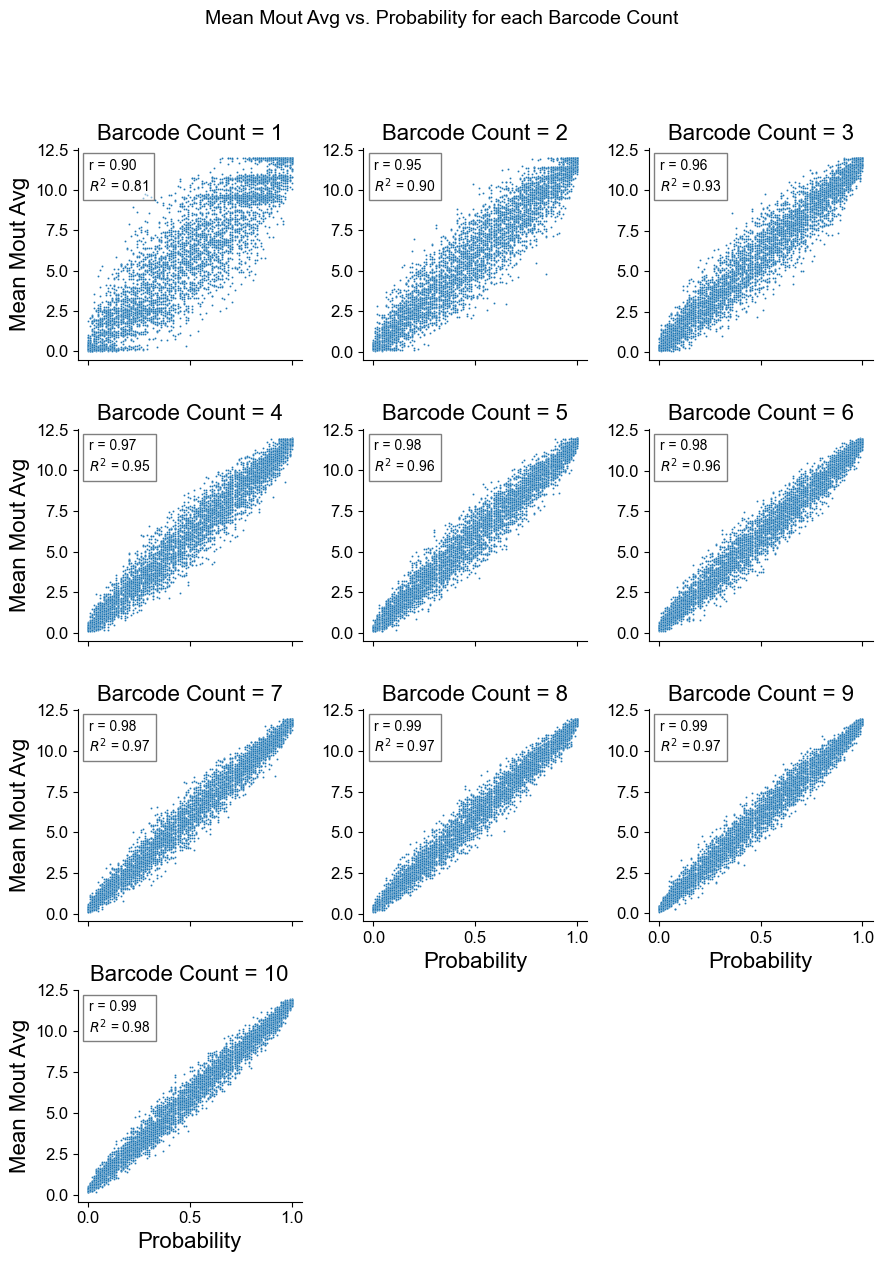

In [8]:
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Pearson correlation and R2
def calculate_metrics(df):
    r_value, _ = pearsonr(df['Probability'], df['Mean Mout Avg'])
    # For R2, square the Pearson correlation coefficient
    r_squared = r_value ** 2
    return r_value, r_squared

# Calculate Pearson correlation and R2 for each 'Barcode Count'
metrics = results_df.groupby('Barcode Count').apply(lambda df: calculate_metrics(df)).to_dict()

# Create a FacetGrid
g = sns.FacetGrid(results_df, col="Barcode Count", col_wrap=3, height=3, sharey=False)
g.map_dataframe(sns.scatterplot, 'Probability', 'Mean Mout Avg', s=2)

# Add the Pearson correlation and R2 as text on each plot
for ax, (barcode_count, (r_value, r_squared)) in zip(g.axes.flat, metrics.items()):
    ax.text(0.05, 0.95, f'r = {r_value:.2f}\n$R^2$ = {r_squared:.2f}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.5))

# Add axis labels and title
g.set_axis_labels('Probability', 'Mean Mout Avg')
g.fig.suptitle('Mean Mout Avg vs. Probability for each Barcode Count', y=1.05, fontsize=14)

# Adjust layout
g.tight_layout()

plt.show()

# Fig. 5A

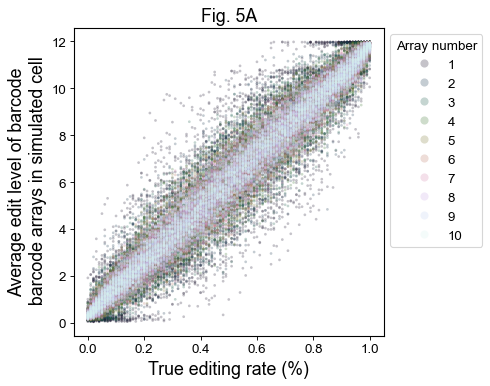

In [9]:
custom_palette = sns.color_palette("cubehelix", 10)
plt.figure(figsize=(5, 5), dpi=80)

temp_df = results_df.loc[results_df['Barcode Count'] < 11].copy()
#temp_df = results_df[results_df['Barcode Count'].isin([ 1, 2, 3, 4, 5, 7, 9])].copy()

# Create scatter plot
scatter = sns.scatterplot(data=temp_df, x='Probability', y='Mean Mout Avg', hue='Barcode Count', palette=custom_palette, s=6, alpha=0.25, edgecolor='none')

# Add axis labels and title
scatter.set_xlabel('True editing rate (%)')
scatter.set_ylabel('Average edit level of barcode\n barcode arrays in simulated cell')
scatter.set_title('Fig. 5A')

# Add legend
plt.legend(title='Array number',bbox_to_anchor=(1, 1), loc='upper left', markerscale=3)
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)
#save_path = os.path.join(BC8_dir, f'binomial simulation of cell states.tif')
#plt.savefig(save_path, dpi=300, format='tif', transparent=True)
plt.show()

# Fig. 5B

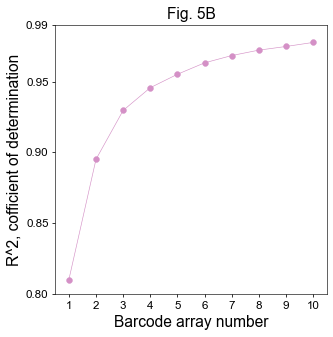

In [10]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculate the R^2 for each 'Barcode Count'
r_squared_values = results_df.groupby('Barcode Count').apply(lambda df: pearsonr(df['Probability'], df['Mean Mout Avg'])[0] ** 2)

# Convert R^2 values to a DataFrame
r_squared_df = r_squared_values.reset_index()
r_squared_df.columns = ['Barcode Count', 'R^2']

# Define the custom color palette (assuming it matches your project style)
custom_palette = sns.color_palette("cubehelix", 5)

# Plot the R^2 for each 'Barcode Count' as a point plot
plt.figure(figsize=(5, 5), dpi=70)
sns.pointplot(x='Barcode Count', y='R^2', data=r_squared_df, markers='o', linewidth=0.625, markersize=6, color=custom_palette[3])

# Add title and labels
plt.title('Fig. 5B')
plt.xlabel('Barcode array number')
plt.ylabel('R^2, cofficient of determination')

# Customize the y-axis
plt.ylim(0.8, 0.98)  # Set y-axis range
plt.yticks(ticks=[0.8, 0.85, 0.9, 0.95, 0.99])  # Set specific ticks and labels


# Adjust axis spines' line width for a cleaner look
plt.gca().spines['bottom'].set_linewidth(0.625)
plt.gca().spines['left'].set_linewidth(0.625)
plt.gca().spines['top'].set_linewidth(0.625)
plt.gca().spines['right'].set_linewidth(0.625)

# Define the save path
#save_path = os.path.join(BC8_dir, 'R_squared_between_predicted_and_true_editing_rate.svg')
#plt.savefig(save_path, dpi=300, format='svg', transparent=True)
# Show the plot
plt.show()


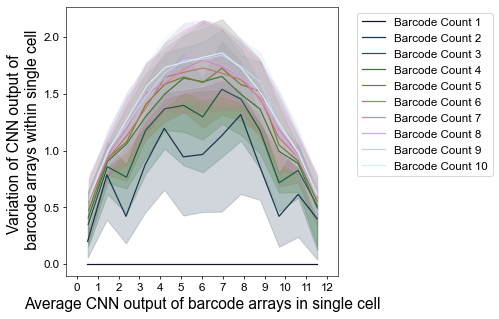

In [46]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=70)

custom_palette = sns.color_palette("cubehelix", 10)

temp_df = results_df.copy(deep=True)  # Deep copy to avoid modifying the original DF

# Function to calculate median and IQR for binned data and plot it
def plot_binned_median_iqr(df, x_col, y_col, hue_col, palette):
    for hue_val in df[hue_col].unique():
        subset_df = df[df[hue_col] == hue_val].copy()  # Avoid SettingWithCopyWarning
        subset_df.loc[:, 'binned'] = pd.cut(subset_df[x_col], bins=13)
        
        median_df = subset_df.groupby('binned')[y_col].median()
        q1_df = subset_df.groupby('binned')[y_col].quantile(0.25)
        q3_df = subset_df.groupby('binned')[y_col].quantile(0.75)
        
        bin_centers = [interval.mid for interval in median_df.index if not pd.isna(interval.mid)]

        # Ensure valid color selection
        color = palette.get(hue_val, 'gray')

        # Plot IQR
        plt.fill_between(bin_centers, q1_df, q3_df, color=color, alpha=0.2)

        # Plot median
        plt.plot(bin_centers, median_df, color=color, linewidth=1.25, label=f'{hue_col} {hue_val}')

# Define the palette based on the unique hue values
unique_hues = temp_df['Barcode Count'].unique()
palette = dict(zip(unique_hues, sns.color_palette("cubehelix", len(unique_hues))))

# Plot binned median and IQR for each hue
plot_binned_median_iqr(temp_df, 'Mean Mout Avg', 'Std Mout Avg', 'Barcode Count', palette)

# Labels and limits
plt.xlabel('Average CNN output of barcode arrays in single cell')
plt.ylabel('Variation of CNN output of \n barcode arrays within single cell')
plt.xlim([-0.5, 12.5])
plt.xticks(np.arange(0, 13, 1))  # X-axis: 0 to 12 with interval 1

# Customize spines
for spine in ['top', 'right', 'bottom', 'left']:
    plt.gca().spines[spine].set_linewidth(0.625)

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3)

# Optional save path
# save_path = os.path.join(data_dir, '240812_Wnt_BC1_readout&writing_noise_with_binned_IQR.svg')
# plt.savefig(save_path, dpi=300, format='svg', transparent=True)

plt.show()
